In [492]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import warnings 

In [493]:
warnings.filterwarnings(action = 'ignore')
plt.rc('font', family = 'malgun gothic')

In [494]:
df = pd.read_csv('C:/Users/whileduck/Desktop/code/daycon_train.csv')

In [495]:
from sklearn.metrics import roc_curve,auc,precision_score,recall_score,f1_score,accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [496]:
x_train,x_test, y_train,y_test = train_test_split(df.drop('전화해지여부',axis = 1), df['전화해지여부'], test_size = 0.05, random_state = 42, stratify = df['전화해지여부'])

In [499]:
logist = LogisticRegression(C = 0, max_iter = 100, penalty = 'none')

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 27, max_features = 'auto', max_leaf_nodes = 50)

knn = KNeighborsClassifier(n_neighbors = 11, p = 1, weights = 'distance')

rf = RandomForestClassifier(max_depth = 25, max_features = 'sqrt')

xgb_model = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.15, max_depth = 8 , n_estimators = 1000)

model_cat = CatBoostClassifier(max_depth=10, learning_rate=0.1)

model_lgbm = LGBMClassifier(n_estimators = 1000, learning_rate=  0.5,min_child_samples = 20, num_leaves = 100)

In [501]:
models = [logist,knn,tree,rf, xgb_model,model_cat,model_lgbm]

fitting_time = []

valid_predict = []
valid_predict_time = []

valid_score = []
valid_score_time = []

for model in models:
    
    print(model)
    

    start_time = time()
    model.fit(x_train,y_train)
    end_time = time()
        
    fitting_time.append(end_time - start_time)
    
    start_time = time()
    valid_predict.append(cross_val_predict(model,x_train,y_train,cv = 3))
    end_time = time() # 교차검증 시간 측정
    
    valid_predict_time.append(end_time - start_time)
    
    start_time = time()
    valid_score.append(np.mean(cross_val_score(model,x_train,y_train, cv = 3,scoring = 'f1_micro')))
    end_time = time() # 교차검증 점수 시간 측정
    
    valid_score_time.append(end_time - start_time)

LogisticRegression(C=0, penalty='none')
KNeighborsClassifier(n_neighbors=11, p=1, weights='distance')
DecisionTreeClassifier(max_depth=27, max_features='auto', max_leaf_nodes=50)
RandomForestClassifier(max_depth=25, max_features='sqrt')
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
0:	learn: 0.61

In [502]:
test_predict_time = []
predict_list = []
predict_proba_list = []
accuracy = []
recall = []
f1 = []
precision = []

for model in models:
    
    start_time = time()
    predict = model.predict(x_test)
    predict_proba_list.append(model.predict_proba(x_test)[:,1])
    end_time = time()
    
    test_predict_time.append(end_time - start_time)
    predict_list.append(predict)
    
    start_time = time()
    accuracy.append(accuracy_score(y_test,predict))
    recall.append(recall_score(y_test,predict))
    f1.append(f1_score(y_test,predict, average = 'micro'))
    precision.append(precision_score(y_test,predict))
    
unique_freq = [np.unique(uni,return_counts = True)[1] for uni in predict_list]

In [503]:
models_name = ['LogisticRegression','KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier','XBGClassifier','CatBoostClassifier','LGBMClassifier']

result = pd.DataFrame({'fitting_time':fitting_time,
              'validation_predict_time':valid_predict_time,
              'validation_scroe_time':valid_score_time,
              'validation_avg_f1_score':valid_score,
              'Negative_Positive':unique_freq,
              'test_predict_time':test_predict_time,
              'test_accuracy_score':accuracy,
              'test_recall_score':recall,
              'test_f1_score':f1,
              'test_precision_score':precision},
              index = models_name)

result = result.reset_index()
result

,index,fitting_time,validation_predict_time,validation_scroe_time,validation_avg_f1_score,Negative_Positive,test_predict_time,test_accuracy_score,test_recall_score,test_f1_score,test_precision_score
0,LogisticRegression,0.105464,0.193151,0.200816,0.890136,[1510],0.002005,0.890066,0.000000,0.890066,0.000000
1,KNeighborsClassifier,0.002593,12.562618,12.499336,0.917044,"[1393, 117]",2.022755,0.935762,0.560241,0.935762,0.794872
2,DecisionTreeClassifier,0.036766,0.132807,0.135562,0.890624,"[1496, 14]",0.002441,0.892715,0.054217,0.892715,0.642857
3,RandomForestClassifier,5.851673,11.382013,14.286808,0.911328,"[1425, 85]",0.071587,0.923841,0.409639,0.923841,0.800000
4,XBGClassifier,13.742248,27.232911,25.934254,0.920948,"[1397, 113]",0.018420,0.927815,0.512048,0.927815,0.752212
5,CatBoostClassifier,39.824882,123.316848,127.088324,0.917811,"[1396, 114]",0.008094,0.927152,0.512048,0.927152,0.745614
6,LGBMClassifier,4.802021,10.699095,10.749934,0.920634,"[1385, 125]",0.033809,0.930464,0.560241,0.930464,0.744000


In [504]:
def make_bar_graph(df,value):
    
    
    graph_df = df.sort_values(by = value, ascending = False)
    
    ax = sns.barplot(data = graph_df,
                x = value,
                y = 'index',
                palette = 'Blues_r')
    
    ax.set_title(f'Model 별 {value}')
    ax.set_ylabel('')
    ax.set_xlabel('')
   
    ax.bar_label(ax.containers[0])


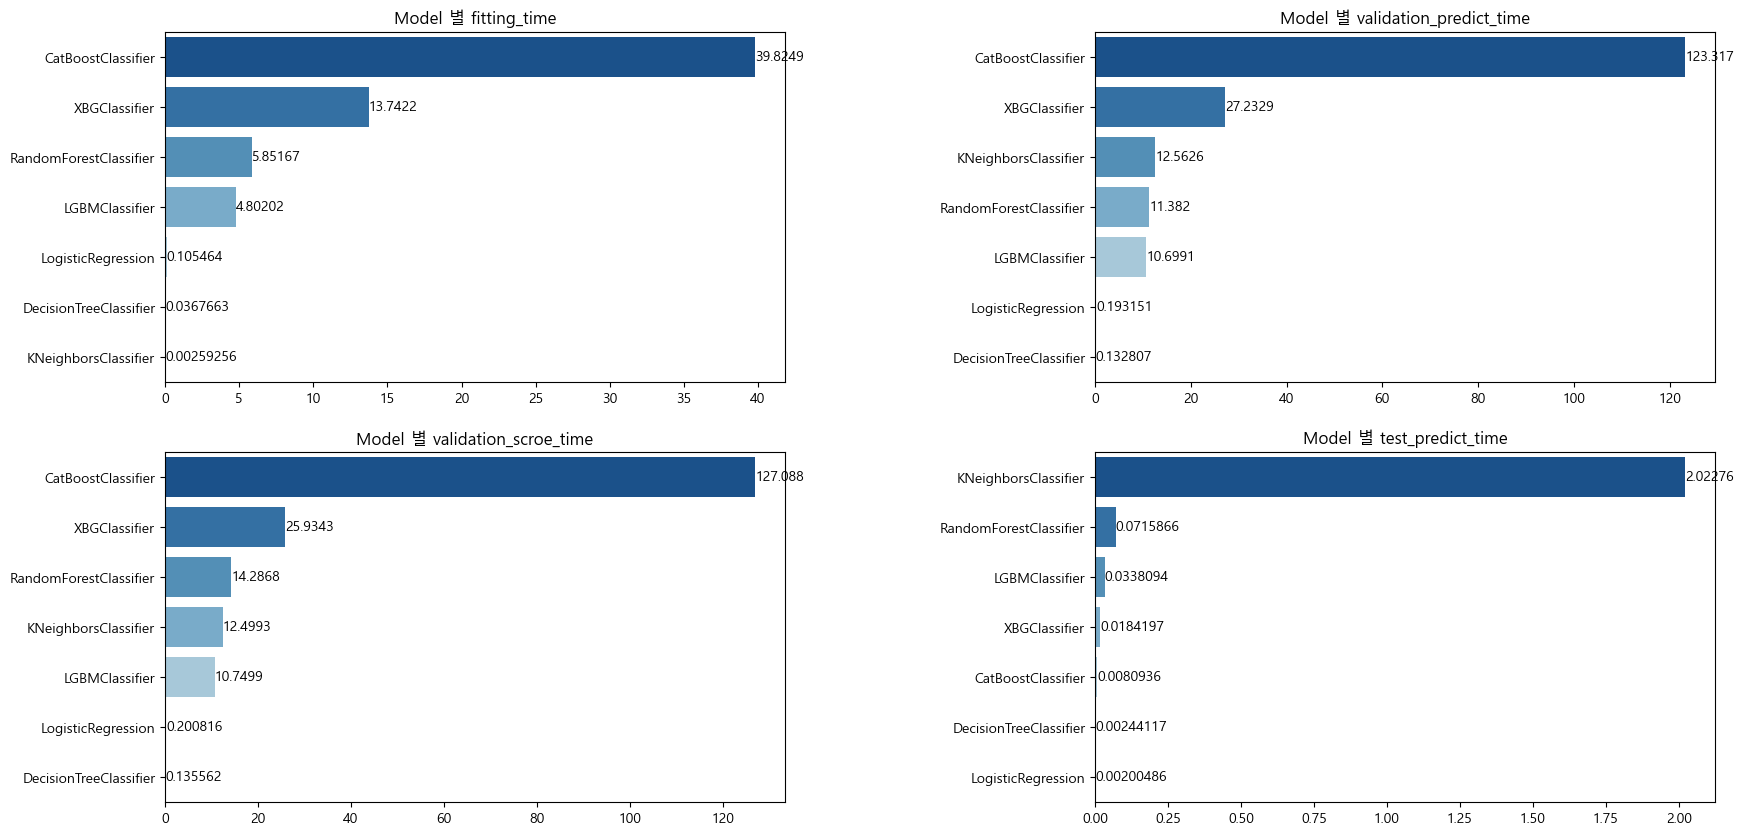

In [505]:
plt.figure(figsize = [20,10])
plt.subplots_adjust(wspace = 0.5)

cols = ['fitting_time', 'validation_predict_time',
        'validation_scroe_time', 'test_predict_time']

for num,col in enumerate(cols):
    
    plt.subplot(2,2,num+1)
    make_bar_graph(result,col)
#     make_line_graph(result,col)

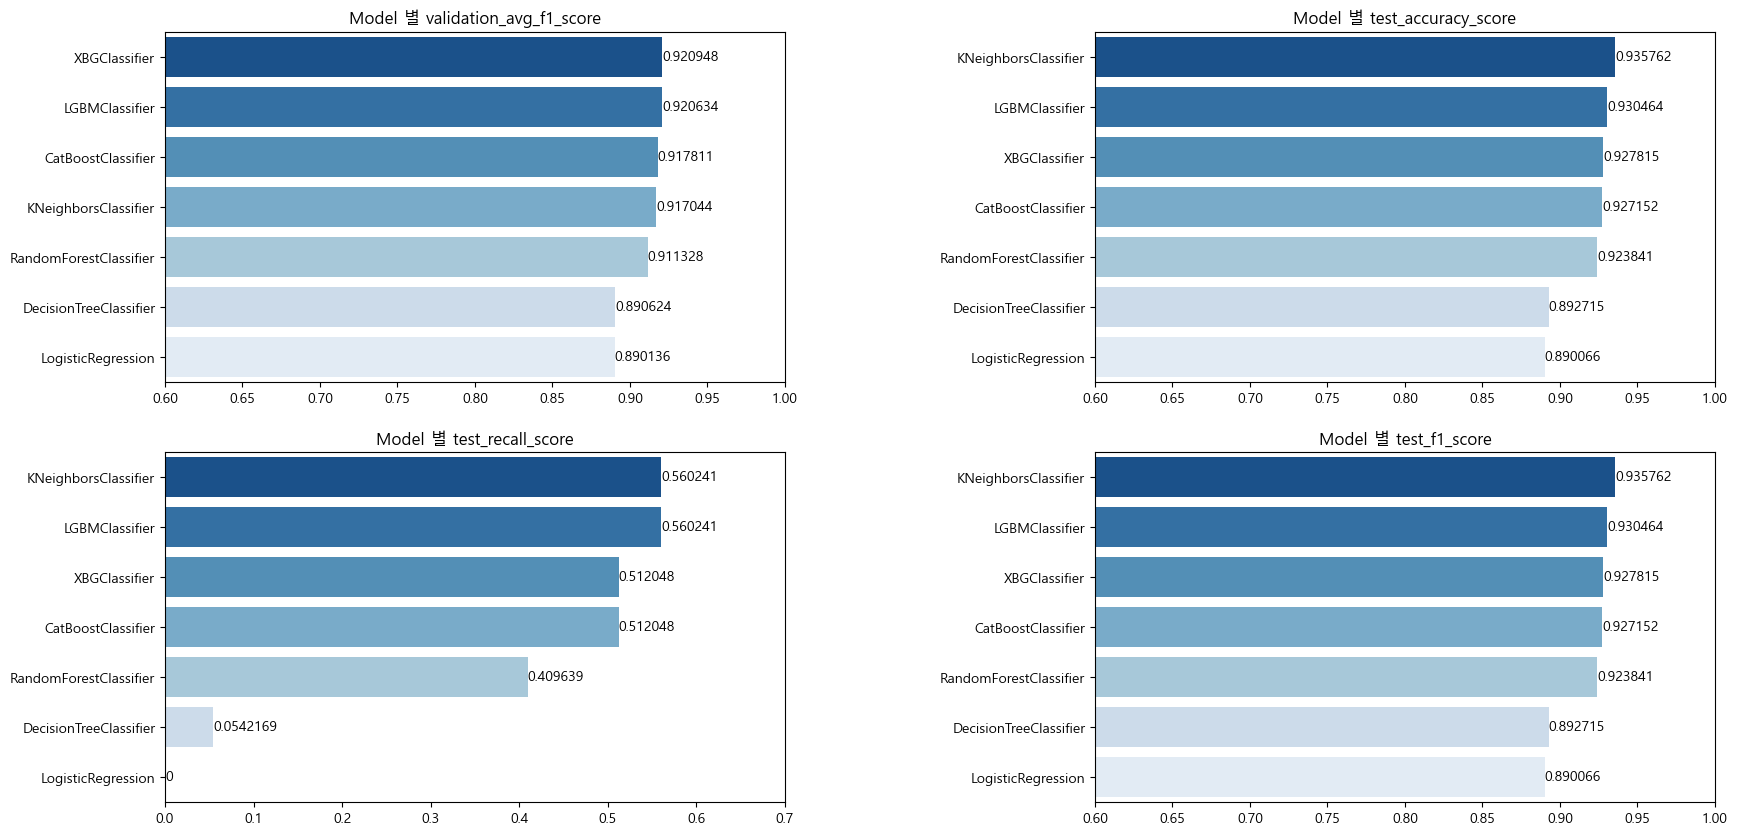

In [519]:
plt.figure(figsize = [20,10])
plt.subplots_adjust(wspace = 0.5)

cols = ['validation_avg_f1_score','test_accuracy_score', 'test_recall_score',
       'test_f1_score']

for num,col in enumerate(cols):
    
    plt.subplot(2,2,num+1)
    
    make_bar_graph(result,col)
    
    if num + 1 == 3:
        plt.xlim([0,0.7])
    else:
        plt.xlim([0.6,1])

In [520]:
def correct_graph(target,predict):
    
    for i,var in enumerate(target):
        
        if var == predict[i]:
            plt.scatter(i,var, c = 'b')
            
    
    
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([0,1],['해지안함','해지'])

In [521]:
def incorrect_graph(target,predict):
    
    for i,var in enumerate(target):
        
        if var != predict[i]:
            plt.scatter(i,var, c = 'r')
            
    
    
    plt.xlabel('')
    plt.ylabel('')
    
    plt.yticks([0,1],['해지안함','해지'])
     

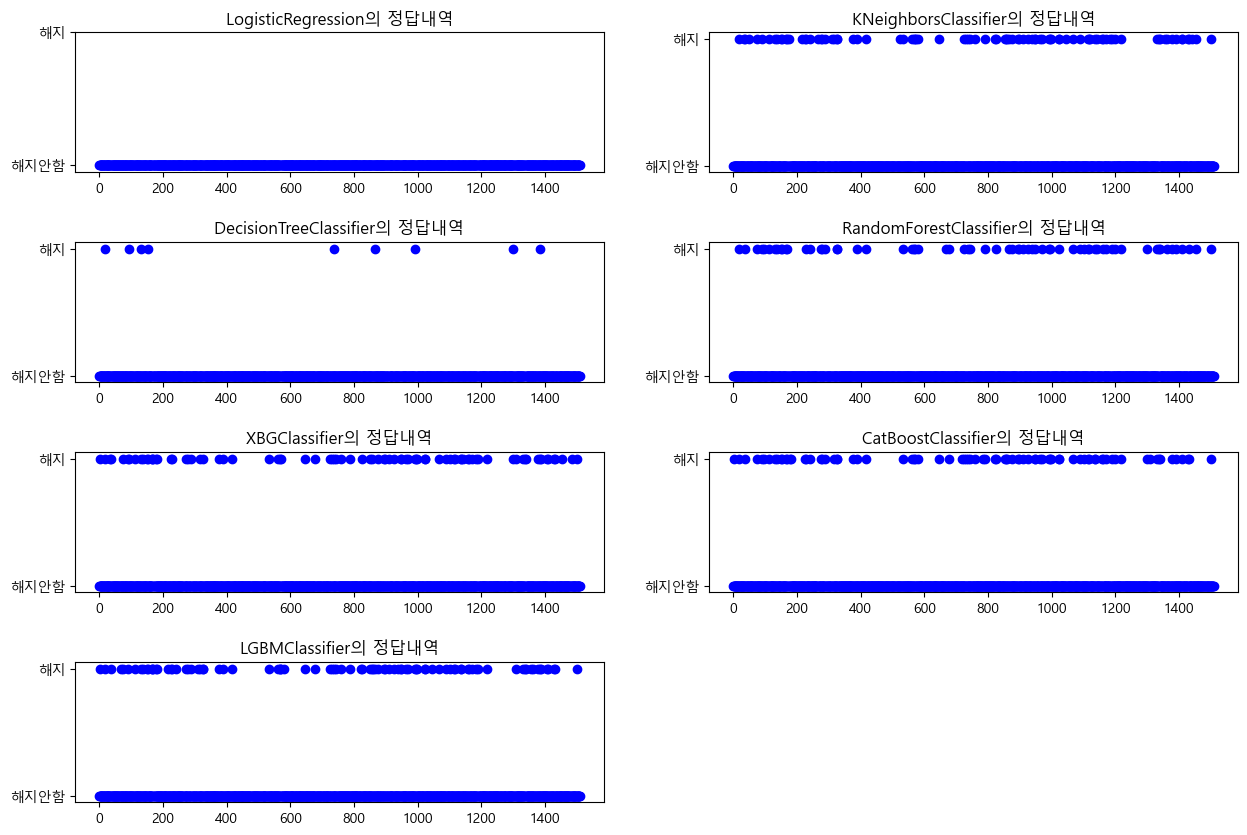

In [522]:
plt.figure(figsize = [15,10])
plt.subplots_adjust(hspace = 0.5)
cols = result['index']

for num in range(7):
    
    plt.subplot(4,2,num+1)
    
    correct_graph(y_test,predict_list[num])
    plt.title(f'{cols[num]}의 정답내역')

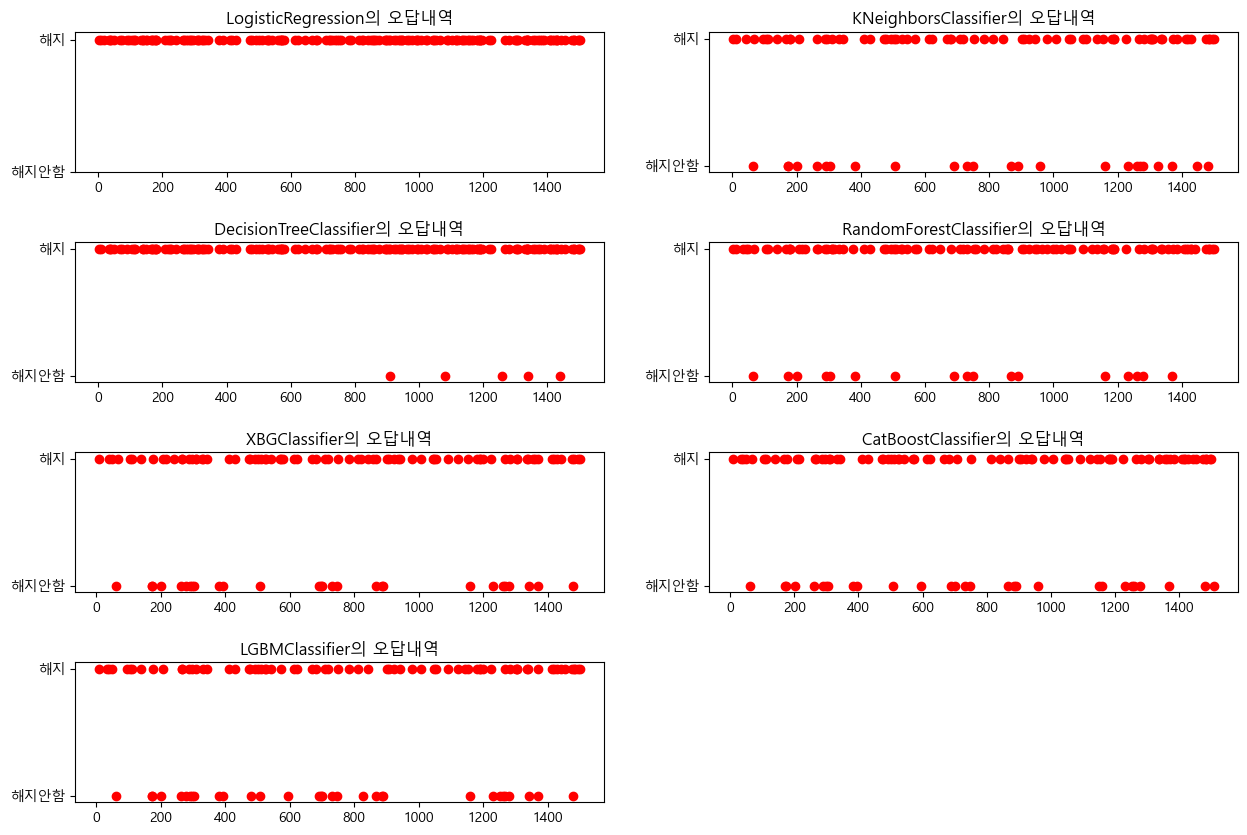

In [523]:
plt.figure(figsize = [15,10])
plt.subplots_adjust(hspace = 0.5)
cols = result['index']

for num in range(7):
    
    plt.subplot(4,2,num+1)
    
    incorrect_graph(y_test,predict_list[num])
    plt.title(f'{cols[num]}의 오답내역')

### 정답 내역에 대한 민감도가 매우 떨어지는 모습이 보이므로 Threshold 를 수정해야 할 필요를 느낀다.

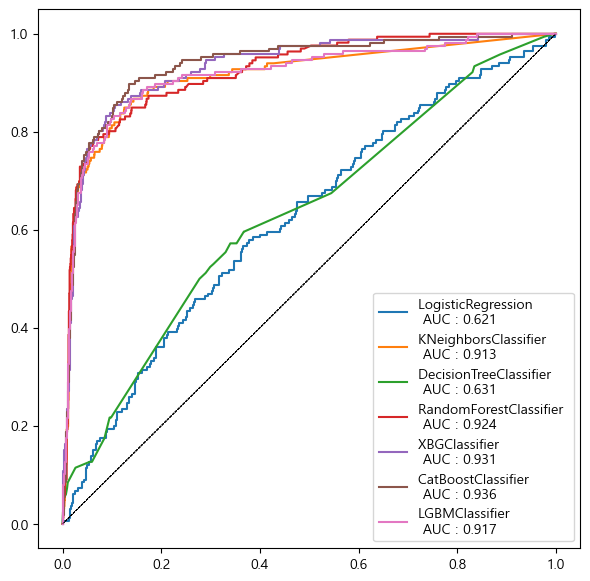

In [524]:
plt.figure(figsize = [7,7])
for num,var in enumerate(predict_proba_list):
    
    fpr,tpr,_ = roc_curve(y_test,var)
    model_auc = round(auc(fpr,tpr),3)
    
    plt.plot(fpr,tpr, label = f'{models_name[num]} \n AUC : {model_auc}')
    plt.plot([0,1],[0,1], ls = '--', c = 'black', lw = 0.5)
    plt.legend(loc = 'lower right', prop = {'size' : 10})
    

In [527]:
proba = knn.predict_proba(test)[:,1]

knn_result = np.where(proba > 0.437, 1 ,0 )

In [528]:
sub = pd.read_csv('C:/Users/whileduck/Desktop/code/dataset/sample_submission.csv')

sub['전화해지여부'] = knn_result

In [530]:
sub.set_index('ID').to_csv('KNN_전처리.csv')